To run this tutorial, you'll need to run the following command in `terminal` (Mac) or `powershell` (Windows) to install `mplstereonet` from the loop3d server:

```bash
% conda install -c loop3d mplstereonet 
```


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import pandas as pd
import mplstereonet as mpls
import numpy.random as random
from past.utils import old_div
%matplotlib inline

The following are some helper functions from the `pmagpy` package (Tauxe _et al._ 2016)

In [5]:
def fishrot(k=20, n=100, dec=0, inc=90, di_block=True):
    """
    Generates Fisher distributed unit vectors from a specified distribution
    using the pmag.py fshdev and dodirot functions.

    Parameters
    ----------
    k : kappa precision parameter (default is 20)
    n : number of vectors to determine (default is 100)
    dec : mean declination of distribution (default is 0)
    inc : mean inclination of distribution (default is 90)
    di_block : this function returns a nested list of [dec,inc,1.0] as the default
    if di_block = False it will return a list of dec and a list of inc

    Returns
    ---------
    di_block : a nested list of [dec,inc,1.0] (default)
    dec, inc : a list of dec and a list of inc (if di_block = False)

    Examples
    --------
    >>> fishrot(k=20, n=5, dec=40, inc=60)
    [[44.766285502555775, 37.440866867657235, 1.0],
     [33.866315796883725, 64.732532250463436, 1.0],
     [47.002912770597163, 54.317853800896977, 1.0],
     [36.762165614432547, 56.857240672884252, 1.0],
     [71.43950604474395, 59.825830945715431, 1.0]]
    """
    directions = []
    declinations = []
    inclinations = []
    if di_block == True:
        for data in range(n):
            d, i = fshdev(k)
            drot, irot = dodirot(d, i, dec, inc)
            directions.append([drot, irot, 1.])
        return directions
    else:
        for data in range(n):
            d, i = fshdev(k)
            drot, irot = dodirot(d, i, dec, inc)
            declinations.append(drot)
            inclinations.append(irot)
        return declinations, inclinations

def fshdev(k):
    """
    Generate a random draw from a Fisher distribution with mean declination
    of 0 and inclination of 90 with a specified kappa.

    Parameters
    ----------
    k : kappa (precision parameter) of the distribution
        k can be a single number or an array of values

    Returns
    ----------
    dec, inc : declination and inclination of random Fisher distribution draw
               if k is an array, dec, inc are returned as arrays, otherwise, single values
    """
    k = np.array(k)
    if len(k.shape) != 0:
        n = k.shape[0]
    else:
        n = 1
    R1 = random.random(size=n)
    R2 = random.random(size=n)
    L = np.exp(-2 * k)
    a = R1 * (1 - L) + L
    fac = np.sqrt(-np.log(a)/(2 * k))
    inc = 90. - np.degrees(2 * np.arcsin(fac))
    dec = np.degrees(2 * np.pi * R2)
    if n == 1:
        return dec[0], inc[0]  # preserve backward compatibility
    else:
        return dec, inc


def dodirot(D, I, Dbar, Ibar):
    """
    Rotate a direction (declination, inclination) by the difference between
    dec=0 and inc = 90 and the provided desired mean direction

    Parameters
    ----------
    D : declination to be rotated
    I : inclination to be rotated
    Dbar : declination of desired mean
    Ibar : inclination of desired mean

    Returns
    ----------
    drot, irot : rotated declination and inclination
    """
    d, irot = dogeo(D, I, Dbar, 90. - Ibar)
    drot = d - 180.
    if drot < 360.:
        drot = drot + 360.
    if drot > 360.:
        drot = drot - 360.
    return drot, irot

def dogeo(dec, inc, az, pl):
    """
    Rotates declination and inclination into geographic coordinates using the
    azimuth and plunge of the X direction (lab arrow) of a specimen.

    Parameters
    ----------
    dec : declination in specimen coordinates
    inc : inclination in specimen coordinates

    Returns
    -------
    rotated_direction : tuple of declination, inclination in geographic coordinates

    Examples
    --------
    >>> pmag.dogeo(0.0,90.0,0.0,45.5)
    (180.0, 44.5)
    """
    A1, A2, A3 = [], [], []  # set up lists for rotation vector
    # put dec inc in direction list and set  length to unity
    Dir = [dec, inc, 1.]
    X = dir2cart(Dir)  # get cartesian coordinates
#
#   set up rotation matrix
#
    A1 = dir2cart([az, pl, 1.])
    A2 = dir2cart([az + 90., 0, 1.])
    A3 = dir2cart([az - 180., 90. - pl, 1.])
#
# do rotation
#
    xp = A1[0] * X[0] + A2[0] * X[1] + A3[0] * X[2]
    yp = A1[1] * X[0] + A2[1] * X[1] + A3[1] * X[2]
    zp = A1[2] * X[0] + A2[2] * X[1] + A3[2] * X[2]
#
# transform back to dec,inc
#
    Dir_geo = cart2dir([xp, yp, zp])
    return Dir_geo[0], Dir_geo[1]    # send back declination and inclination

def dir2cart(d):
    """
    Converts a list or array of vector directions in degrees (declination,
    inclination) to an array of the direction in cartesian coordinates (x,y,z)

    Parameters
    ----------
    d : list or array of [dec,inc] or [dec,inc,intensity]

    Returns
    -------
    cart : array of [x,y,z]

    Examples
    --------
    >>> pmag.dir2cart([200,40,1])
    array([-0.71984631, -0.26200263,  0.64278761])
    """
    ints = np.ones(len(d)).transpose()  # get an array of ones to plug into dec,inc pairs
    d = np.array(d)
    rad = np.pi/180.
    if len(d.shape) > 1:  # array of vectors
        decs, incs = d[:, 0] * rad, d[:, 1] * rad
        if d.shape[1] == 3:
            ints = d[:, 2]  # take the given lengths
    else:  # single vector
        decs, incs = np.array(float(d[0])) * rad, np.array(float(d[1])) * rad
        if len(d) == 3:
            ints = np.array(d[2])
        else:
            ints = np.array([1.])
    cart = np.array([ints * np.cos(decs) * np.cos(incs), ints *
                     np.sin(decs) * np.cos(incs), ints * np.sin(incs)]).transpose()
    return cart

def cart2dir(cart):
    """
    Converts a direction in cartesian coordinates into declination, inclinations

    Parameters
    ----------
    cart : input list of [x,y,z] or list of lists [[x1,y1,z1],[x2,y2,z2]...]

    Returns
    -------
    direction_array : returns an array of [declination, inclination, intensity]

    Examples
    --------
    >>> pmag.cart2dir([0,1,0])
    array([ 90.,   0.,   1.])
    """
    cart = np.array(cart)
    rad = old_div(np.pi, 180.)  # constant to convert degrees to radians
    if len(cart.shape) > 1:
        Xs, Ys, Zs = cart[:, 0], cart[:, 1], cart[:, 2]
    else:  # single vector
        Xs, Ys, Zs = cart[0], cart[1], cart[2]
    if np.iscomplexobj(Xs):
        Xs = Xs.real
    if np.iscomplexobj(Ys):
        Ys = Ys.real
    if np.iscomplexobj(Zs):
        Zs = Zs.real
    Rs = np.sqrt(Xs**2 + Ys**2 + Zs**2)  # calculate resultant vector length
    # calculate declination taking care of correct quadrants (arctan2) and
    # making modulo 360.
    Decs = (old_div(np.arctan2(Ys, Xs), rad)) % 360.
    try:
        # calculate inclination (converting to degrees) #
        Incs = old_div(np.arcsin(old_div(Zs, Rs)), rad)
    except:
        print('trouble in cart2dir')  # most likely division by zero somewhere
        return np.zeros(3)

    return np.array([Decs, Incs, Rs]).transpose()  # return the directions list

In [21]:
bimodal_data=fishrot(k=50,n=25,dec=33,inc=41) + fishrot(k=100,n=30,dec=250,inc=68)
trends = np.array(bimodal_data)[:,0]
plunges = np.array(bimodal_data)[:,1]
for di in bimodal_data:
    print ('%7.1f %7.1f'%(di[0],di[1]))

   35.8    43.1
   36.9    46.2
   53.2    49.6
    9.9    39.5
   35.5    24.6
   30.1    26.3
   30.9    49.9
   54.5    34.9
   51.0    50.4
   36.4    36.9
   21.7    30.2
   24.3    40.4
   29.4    28.7
   40.5    46.0
   26.6    41.4
   43.3    36.5
   35.1    32.3
   36.2    41.0
   32.3    47.5
   33.8    34.5
   24.9    31.5
   29.4    45.3
   26.6    33.4
   34.5    39.2
   25.9    44.2
  232.2    60.6
  224.2    63.6
  251.8    58.1
  245.0    62.8
  259.3    80.7
  262.3    66.2
  234.2    64.2
  253.7    63.5
  228.7    76.8
  227.6    58.8
  255.6    54.1
  219.2    79.4
  223.5    70.1
  247.8    66.8
  258.3    68.3
  257.1    62.0
  254.8    63.9
  242.1    72.8
  250.8    71.2
  254.8    62.6
  233.5    60.3
  247.5    75.1
  253.5    74.1
  244.4    79.6
  274.2    63.7
  254.1    76.2
  240.3    78.9
  260.3    56.6
  243.7    64.6
  236.0    61.6


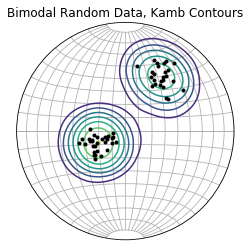

In [34]:
fig, ax = mpls.subplots()

cax = ax.density_contour(plunges, trends, measurement='lines', method='linear_kamb')

ax.line(plunges, trends, 'k.')
ax.grid(True)
#fig.colorbar(cax)
ax.set_title('Bimodal Random Data, Kamb Contours')
ax.set_azimuth_ticks([])

plt.show()